<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Contents:
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Machine Learning Models](#Machine-Learning-Models)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Import libraries

In [1]:
import pandas as pd
import string
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier


## Data Cleaning

### Import Data

In [2]:
# Set the display option to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Import data from our web scrapping jupyter notebook
df = pd.read_csv("../data/df.csv")

In [4]:
# Class 0 = Avoidant
# Class 1 = Anxious

df.sample(10)

,Unnamed: 0,Title,Post Text,ID,Score,Total Comments,Post URL,subreddit,class
838,838,Weekly Relationship Thread: Ask Avoidants,This is a post for non-avoidants to ask advice...,11ef8r4,18,17,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
1189,1189,"{fa} kissy emoji and ""thinking of you"" texts r...",Looking for advice. I'm male FA dating who som...,vrfli4,7,15,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
75,75,"I do it to myself, I do, and thats why it real...",I recently came to a crushing realization that...,s74xgw,80,16,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
2609,1254,Navigating the absence of touch?,I took a bit of a turn to a tiktok rabbit hole...,12iqp4w,5,4,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
1033,1033,Accountability question {fa},How do you know when it’s a “those are their f...,117rfw2,10,9,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
2046,691,In defense of texting delays,I don’t always respond quickly to texts. Not t...,103v1np,44,40,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
2618,1263,This feels emotionally abusive,"I don't think he intends to do this, but the p...",12hrsqm,30,6,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
1742,387,A few coping questions my therapist shared wit...,What am I feeling right now?\n\nHow is this fa...,sjztnk,68,6,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
669,669,i hate how i want emotionally unavailable people,i noticed i started liking this girl when she ...,paocic,22,7,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
1154,1154,"{da} I first heard this song a while ago, but ...",NaN,wli2si,11,19,https://youtu.be/_GwqgZ9pW6w,AvoidantAttachment,0


In [6]:
# Rename the 'Title' column
df["text"] = df["Title"]

In [7]:
# Check that the X values ('text' column) and y values ('class' column) do not have missing values
df.isna().sum()

Unnamed: 0          0
Title               0
Post Text         336
ID                  0
Score               0
Total Comments      0
Post URL            0
subreddit           0
class               0
text                0
dtype: int64

In [8]:
# Check the number of rows for each class
df["class"].value_counts()

1    1811
0    1355
Name: class, dtype: int64

In [9]:
# Dataframe info
df.describe()

,Unnamed: 0,Score,Total Comments,class
count,3166.000000,3166.000000,3166.000000,3166.000000
mean,807.419457,42.188566,17.218572,0.572015
std,484.376411,60.832831,23.687478,0.494865
min,0.000000,0.000000,0.000000,0.000000
25%,395.250000,11.000000,5.000000,0.000000
50%,791.000000,26.000000,11.000000,1.000000
75%,1186.750000,48.000000,21.000000,1.000000
max,1810.000000,983.000000,383.000000,1.000000


### Preprocessing

#### Remove special characters

In [10]:
# Remove punctuations and standardise to lowercase

def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

df["text_clean"] = df["text"].apply(lambda x: remove_punct(x.lower()))
df[["text", "text_clean"]].sample(5)

,text,text_clean
2316,Avoidant bf - broken up for good,avoidant bf broken up for good
573,Cutting off avoidant ex,cutting off avoidant ex
2129,I need to lose him to love me.,i need to lose him to love me
1771,Muddy water is best cleared by leaving it alone,muddy water is best cleared by leaving it alone
1918,Newly secure win.,newly secure win


#### Remove URLs

In [11]:
# Remove urls in the text column

def remove_url(text):
    text_nourl = re.sub(r'\S*http\S*', '', text)
    return text_nourl

df["text_clean"] = df["text_clean"].apply(lambda x: remove_url(x))

df[["text", "text_clean"]].sample(10)

,text,text_clean
954,{FA} Is losing sexual interest deactivating too?,fa is losing sexual interest deactivating too
2326,"Dating People Who Seem Open/Vulnerable And ""Se...",dating people who seem openvulnerable and secu...
2961,is there such thing where you become anxious a...,is there such thing where you become anxious a...
545,My inner child is mad at my adult self,my inner child is mad at my adult self
2370,Does it always stem from childhood?,does it always stem from childhood
1666,Have you ever had suicidal thoughts because yo...,have you ever had suicidal thoughts because yo...
3117,What’s wrong with me?,what’s wrong with me
1842,The AP DA Chain.,the ap da chain
753,Huge Question about other avoidants,huge question about other avoidants
318,I just realised the attachment pattern between...,i just realised the attachment pattern between...


#### Remove words that contains digit

In [12]:
def remove_digit(text):
    text_nodigit = re.sub(r'\w*\d\w*', '', text)
    return text_nodigit

df["text_clean"] = df["text_clean"].apply(lambda x: remove_digit(x))

df[["text", "text_clean"]].sample(10)

,text,text_clean
1422,Don’t date or accommodate Avoidants.,don’t date or accommodate avoidants
2893,Is this due to anxious attachment? and how do ...,is this due to anxious attachment and how do i...
118,IMPORTANT: We have changed this sub from Publi...,important we have changed this sub from public...
1343,A question for {Fa}s and {Da}s about love,a question for fas and das about love
1113,{fa} how to deal with the negative stories in ...,fa how to deal with the negative stories in my...
364,{FA} It feels a strange type of good whenever ...,fa it feels a strange type of good whenever my...
1519,Overthinkers unite,overthinkers unite
1704,Feeling really helpless tonight.,feeling really helpless tonight
343,what are your best tips for anxious-avoidant r...,what are your best tips for anxiousavoidant re...
3105,has this ever happened to anyone?,has this ever happened to anyone


#### Tokenize

In [13]:
def tokenize(text):  
    # /W matches any character that is neither alphanumeric nor underscoreb
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    return tokens

df["text_token"] = df["text_clean"].apply(lambda x: tokenize(x)) 
df[["text", "text_token"]].sample(5)

,text,text_token
1135,What's the first step you took towards securit...,"[whats, the, first, step, you, took, towards, ..."
3075,She texted me and im confused,"[she, texted, me, and, im, confused]"
119,Those moments when you can tell you're more se...,"[those, moments, when, you, can, tell, youre, ..."
1456,You are worthy of love ❤️,"[you, are, worthy, of, love, ]"
2315,Thoughts based on what I recently experienced:,"[thoughts, based, on, what, i, recently, exper..."


#### Remove Stopwords

In [14]:
# List of default stopwords
stopword = nltk.corpus.stopwords.words('english')

# Remove stop words
def remove_stopwords(tokenized_list):
    #Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword]
    return text

df["text_stop"] = df["text_token"].apply(lambda x: remove_stopwords(x))
df[["text", "text_stop"]].sample(5)

,text,text_stop
821,"came across this tweet today, now I wonder if ...","[came, across, tweet, today, wonder, da, grow,..."
1825,He usually spends 8 hours once a week with me ...,"[usually, spends, hours, week, said, feels, li..."
1424,Boy do I got news for you....,"[boy, got, news]"
2985,Sharing my story with DA bf,"[sharing, story, da, bf]"
835,Cannot handle AP friends attachment fixation,"[cannot, handle, ap, friends, attachment, fixa..."


#### Lemmatize

In [15]:
# Lemmatizer
wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    #return list of all lemmatized words for their corresponding words in tokenized_text
    text = [wn.lemmatize(word) for word in tokenized_text]
    return ' '.join(text)

df["text_lemmatise"] = df["text_stop"].apply(lambda x: lemmatizing(x))
df[["text", "text_lemmatise"]].sample(5)

,text,text_lemmatise
1870,Stuff that’s been helping me heal <3,stuff helping heal
10,A good meme dump {FA},good meme dump fa
1079,Weekly Relationship Thread: Ask Avoidants,weekly relationship thread ask avoidants
1249,{da} Feeling “eewed” about people coming close...,da feeling eewed people coming close
1695,What are some limiting beliefs that you are cu...,limiting belief currently working


#### Remove duplicate words

In [16]:
# Identify duplicate words between both class
# Separate the text into two lists based on class
class_0_text = df[df['class'] == 0]["text_lemmatise"].tolist()
class_1_text = df[df['class'] == 1]["text_lemmatise"].tolist()

# Function to find and count duplicate words between both classes
def find_duplicate_words_between_classes(df, column_name, class_column_name):
    class_0_text = df[df[class_column_name] == 0][column_name].tolist()
    class_1_text = df[df[class_column_name] == 1][column_name].tolist()
    
    all_words_class_0 = ' '.join(class_0_text).split()
    all_words_class_1 = ' '.join(class_1_text).split()
    
    common_words = set(all_words_class_0).intersection(all_words_class_1)
    
    word_counts_class_0 = Counter(all_words_class_0)
    word_counts_class_1 = Counter(all_words_class_1)
    
    top_common_words_class_0 = {word: word_counts_class_0[word] for word in common_words if word in word_counts_class_0}
    top_common_words_class_1 = {word: word_counts_class_1[word] for word in common_words if word in word_counts_class_1}
    
    return pd.DataFrame({'Duplicate Words': list(common_words), 
                         'Count (Class 0)': [top_common_words_class_0.get(word, 0) for word in common_words],
                         'Count (Class 1)': [top_common_words_class_1.get(word, 0) for word in common_words]})

# Get the DataFrame containing duplicate words and counts for both classes
duplicate_words_df = find_duplicate_words_between_classes(df, "text_lemmatise", "class")

# Calculate the difference in counts between Class 0 and Class 1 for each word
duplicate_words_df['Count Difference'] = (duplicate_words_df['Count (Class 0)'] - duplicate_words_df['Count (Class 1)']).abs()

# Sort the DataFrame by the largest difference in counts (descending order)
duplicate_words_df = duplicate_words_df.sort_values(by='Count Difference', ascending=True)

# Display the duplicate words and counts for both classes
print(duplicate_words_df)
print(duplicate_words_df.shape)

      Duplicate Words  Count (Class 0)  Count (Class 1)  Count Difference
1047           normal                4                4                 0
271            highly                1                1                 0
709            reduce                1                1                 0
269            couple                2                2                 0
268            excuse                1                1                 0
266           suggest                1                1                 0
265         recommend                1                1                 0
714        excitement                1                1                 0
720           someday                1                1                 0
259             inner                4                4                 0
724          silenced                1                1                 0
257           managed                1                1                 0
725              info                2

In [17]:
# Remove list of duplicate words (count difference less than 10)

additional_stopwords = duplicate_words_df[duplicate_words_df['Count Difference'].between(0, 10)]
stopword += additional_stopwords["Duplicate Words"].tolist()

df["text_final"] = df["text_token"].apply(lambda x: remove_stopwords(x))
df["text_final"] = df["text_final"].apply(lambda x: lemmatizing(x))

#### Data for Machine Learning

In [18]:
# Final df for machine learning 
df.head()

,Unnamed: 0,Title,Post Text,ID,Score,Total Comments,Post URL,subreddit,class,text,text_clean,text_token,text_stop,text_lemmatise,text_final
0,0,Seriously though {FA}{DA},NaN,tqnp1u,521,19,https://i.redd.it/vv5etnapy7q81.jpg,AvoidantAttachment,0,Seriously though {FA}{DA},seriously though fada,"[seriously, though, fada]","[seriously, though, fada]",seriously though fada,fada
1,1,For all my favorite avoidants ❤️,NaN,rpvbi1,453,2,https://i.redd.it/8yz268zr05881.jpg,AvoidantAttachment,0,For all my favorite avoidants ❤️,for all my favorite avoidants ❤️,"[for, all, my, favorite, avoidants, ]","[favorite, avoidants, ]",favorite avoidants,avoidants
2,2,Anxious People on this subreddit: stop abandon...,If you’re anxious preoccupied or anxious leani...,plr9xd,438,68,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0,Anxious People on this subreddit: stop abandon...,anxious people on this subreddit stop abandoni...,"[anxious, people, on, this, subreddit, stop, a...","[anxious, people, subreddit, stop, abandoning,...",anxious people subreddit stop abandoning blami...,anxious stop blaming someone else
3,3,Same {FA},NaN,syzhtu,345,6,https://i.redd.it/ta0rdmnlhgj81.jpg,AvoidantAttachment,0,Same {FA},same fa,"[same, fa]",[fa],fa,fa
4,4,❤️,NaN,s32vt3,330,5,https://v.redd.it/tmmv4r4hbhb81,AvoidantAttachment,0,❤️,❤️,"[, ]","[, ]",,


In [19]:
# Class 0 = Avoidant
# Class 1 = Anxious

df.shape

(3166, 15)

## Exploratory Data Analysis

#### EDA on Length and Word Count of post

In [20]:
# Create a new column called post_length that contains the length of each post
df['post_length'] = df['text_final'].map(len)

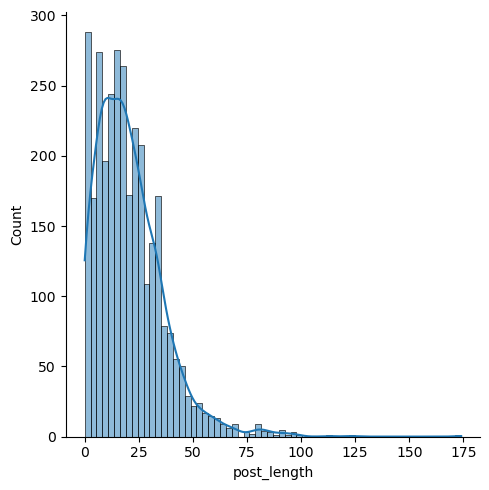

In [21]:
# Explore data on graphs
sns.displot(df['post_length'], kde=True)

In [22]:
# Create a new column called post_word_count that contains the number of words in each post
df['post_word_count'] = df['text_final'].map(lambda x: len(x.split()))

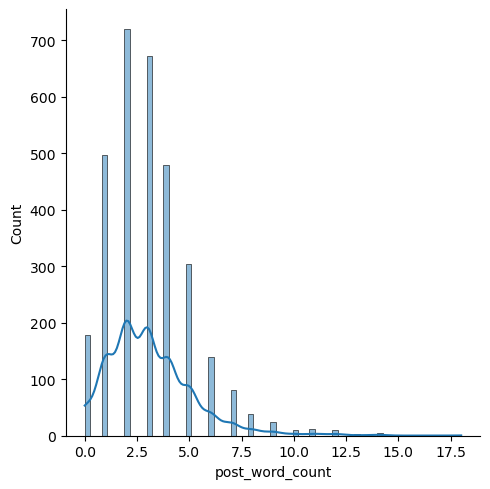

In [23]:
# Explore data on graphs
sns.displot(df['post_word_count'], kde=True)

In [24]:
df["post_word_count"].describe()

count    3166.000000
mean        3.077701
std         2.054463
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        18.000000
Name: post_word_count, dtype: float64

#### EDA on Posts Content

In [39]:
# Show the five shortest posts based off of post_word_count
df.sort_values(by='post_word_count', ascending=True)[['text_final']].head()

,text_final
2556,
595,
1384,
2206,
1391,


In [26]:
# Show the five longest posts based off of post_word_count
df.sort_values(by='post_word_count', ascending=False)[['text_final']].head()

,text_final
2077,partner responsive day unresponsive day attach...
1404,quick im sorry avoidants deactivation attack w...
189,fa boyfriend shower word feel feel uncomfortab...
194,got dog month definitely he avoidant personali...
2330,studying attachment secure stop resenting avoi...


#### EDA on Post Score

In [27]:
# Filter the DataFrame where 'Label' is equal to 0 (Anxious Attachment style)
filtered_df = df[df['class'] == 0]

# Sort the filtered DataFrame by 'Score' in ascending order and show the lowest posts scores
lowest_scores = filtered_df.sort_values(by='Score', ascending=True).head()

lowest_scores['text_final']

1099                               da
1221                fa nonmonogamy fa
1296            fa transition feeling
1243    fa fa relationship friendship
1159         fa relationship avoidant
Name: text_final, dtype: object

In [28]:
# Show the highest posts based off of post scores
#df.sort_values(by='Score', ascending=False).head()

# Filter the DataFrame where 'Label' is equal to 1 (Avoidant Attachment style)
filtered_df = df[df['class'] == 1]

# Sort the filtered DataFrame by 'Score' in ascending order and show the lowest posts scores
highest_scores = filtered_df.sort_values(by='Score', ascending=True).head()

highest_scores['text_final']

3093             back
2570                 
2857    would thought
2840    ex da partner
2968               da
Name: text_final, dtype: object

#### EDA on Duplicated Words

In [29]:
from nltk.tokenize import word_tokenize

class_0_text = df[df["class"] == 0]["text_lemmatise"].tolist()
class_1_text = df[df["class"] == 1]["text_lemmatise"].tolist()
# Tokenize the post text for class 1
tokens_class_1 = []
for text in class_1_text:
    tokens_class_1.extend(word_tokenize(text))
# Tokenize the post text for class 0    
tokens_class_0 = []
for text in class_0_text:
    tokens_class_0.extend(word_tokenize(text))
    
unique_tokens_class_1 = set(tokens_class_1)
unique_tokens_class_0 = set(tokens_class_0)

print(f"Unique words in class 0: {len(unique_tokens_class_0)-len(duplicate_words_df)}")
print(f"Unique words in class 1: {len(unique_tokens_class_1)-len(duplicate_words_df)}")
print(f"Duplicate words in both classes: {len(duplicate_words_df)}")

Unique words in class 0: 906
Unique words in class 1: 1095
Duplicate words in both classes: 1048


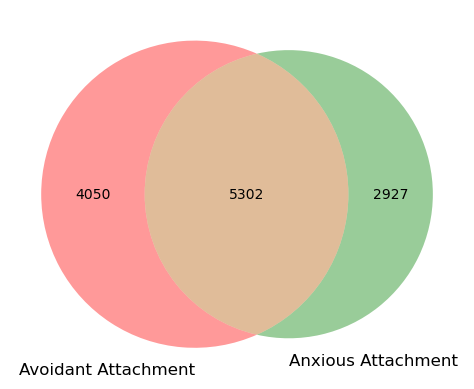

In [30]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

venn2(subsets = (4050, 2927,5302), set_labels = ('Avoidant Attachment', 'Anxious Attachment'))

#### Word Cloud - Anxious Style

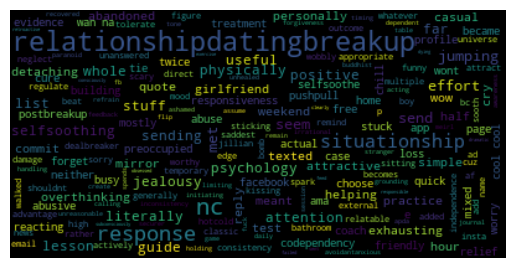

In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

duplicate_word_list = list(duplicate_words_df["Duplicate Words"])
class_1_words = [word for word in tokens_class_1 if word not in duplicate_word_list]

# For Anxious Attachment class 1
text = " ".join(class_1_words)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud - Avoidant Style

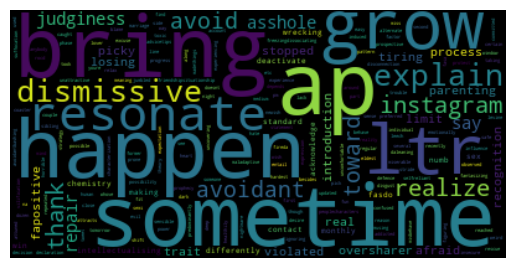

In [32]:
# For Avoidant Attachment class 0

class_0_words = [word for word in tokens_class_0 if word not in duplicate_word_list]

text = " ".join(unique_tokens_class_0)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Machine Learning Models

### Count Vectorizer & Naive Bayes (Bernoulli) Pipeline

#### Baseline Model 

In [33]:
# Initiate train, test, split function
X = df['text_final']
y = df['class']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [34]:
# Create a pipeline for Count Vectorizer and Naive Bayes (Bernoulli)
pipe_cv_berNB = Pipeline([
    ('cvec',  CountVectorizer()),
    ('berNB', BernoulliNB())])
# Define hyperparameters for grid search
pipe_cv_berNB_params = {'cvec__max_features' : [500],  # 100
                        'cvec__ngram_range' : [(1,2)], #(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)
                       'berNB__binarize': [0.0]}       # 0.1, 0.5

# Instantiate GridSearchCV
gs_cv_berNB = GridSearchCV(pipe_cv_berNB, pipe_cv_berNB_params, cv=5)

# Fit GridSearch to training data
gs_cv_berNB.fit(X_train, y_train)

# Best score
print (f'Best Score: {gs_cv_berNB.best_score_}')

# Best parameters
print (f'Best Parameters: {gs_cv_berNB.best_params_}')

# Training score
print (f'Train Score: {gs_cv_berNB.score(X_train, y_train)}')

# Test score
print (f'Test Score: {gs_cv_berNB.score(X_test, y_test)}')

# y predict
y_pred_gs_cv_berNB = gs_cv_berNB.predict(X_test)
print(classification_report(y_test, y_pred_gs_cv_berNB))

Best Score: 0.8812089717965801
Best Parameters: {'berNB__binarize': 0.0, 'cvec__max_features': 500, 'cvec__ngram_range': (1, 2)}
Train Score: 0.9018534119629318
Test Score: 0.8787878787878788
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       339
           1       0.85      0.96      0.90       453

    accuracy                           0.88       792
   macro avg       0.89      0.86      0.87       792
weighted avg       0.89      0.88      0.88       792



### Count Vectorizer & Naive Bayes (Multinomial) Pipeline

In [35]:
# Create a pipeline for Count Vectorizer and Naive Bayes (Multinomial)
pipe_cv_multiNB = Pipeline([
    ('cvec',  CountVectorizer()), 
    ('multiNB', MultinomialNB())])

# Define hyperparameters for grid search
pipe_cv_multiNB_params = {'cvec__max_features' : [100,500],  # comment what you have tried
                        'cvec__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)]}
                        

# Instantiate GridSearchCV    
gs_cv_multiNB = GridSearchCV(pipe_cv_multiNB, pipe_cv_multiNB_params, cv=5)

# Fit GridSearch to training data
gs_cv_multiNB.fit(X_train, y_train)

# Best score
print (f'Best Score: {gs_cv_multiNB.best_score_}')

# Best parameters
print (f'Best Parameters: {gs_cv_multiNB.best_params_}')

# Training score
print (f'Train Score: {gs_cv_multiNB.score(X_train, y_train)}')

# Test score
print (f'Test Score: {gs_cv_multiNB.score(X_test, y_test)}')

# y predict
y_pred_gs_cv_multiNB = gs_cv_multiNB.predict(X_test)
print(classification_report(y_test, y_pred_gs_cv_multiNB))

Best Score: 0.8727923606484567
Best Parameters: {'cvec__max_features': 500, 'cvec__ngram_range': (1, 3)}
Train Score: 0.9005897219882055
Test Score: 0.8800505050505051
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       339
           1       0.86      0.94      0.90       453

    accuracy                           0.88       792
   macro avg       0.89      0.87      0.88       792
weighted avg       0.88      0.88      0.88       792



### Count Vectorizer & Logistic Regression Model

#### Best Model

In [36]:
def cvcvectorize_split_smote_logistic(X, y, test_size=0.4, random_state=42):
    # Step 1: Apply Count Vectorizer
    vectorizer = CountVectorizer(max_features=600, min_df=2, max_df=.9, ngram_range=(1,2))
    X_vectorized = vectorizer.fit_transform(X)
    
    # Parameters tested
    # max_features: [500, 2_000, 3_000, 4_000, 5_000]
    # min_df: [3]
    # max_df: [.95]
    # ngram_range:[(1,1) (2,2)]

    
    # Step 2: Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=test_size, random_state=random_state)
    
    
    # Step 3: Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    
    # Step 4: Train a logistic regression model
    classifier = LogisticRegression(solver='liblinear')
    classifier.fit(X_train_resampled, y_train_resampled) 
    
    
    #Step 5: Retrieve the coefficient and feature names 
    coef = classifier.coef_[0]
    features = vectorizer.get_feature_names_out() 
    feature_importance = pd.DataFrame({'Features': features, 'Importance': coef})
    # Separate positive and negative coefficients
    positive_coeffs = feature_importance[feature_importance['Importance'] > 0]
    negative_coeffs = feature_importance[feature_importance['Importance'] < 0]
    # Find the smallest positive coefficient
    largest_positive_coeff = positive_coeffs.nlargest(50, 'Importance')
    # Find the highest negative coefficient
    smallest_negative_coeff = negative_coeffs.nsmallest(50, 'Importance')
    
    
    # Step 6: Evaluate on training and test data
    train_predictions = classifier.predict(X_train_resampled)
    test_predictions = classifier.predict(X_test)
    
    train_accuracy = accuracy_score(y_train_resampled, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Score model on training set
    print(f'Train Score: {train_accuracy}')
    
    # Score model on testing set
    print(f'Test Score: {test_accuracy}')
    
    # Making predictions
    print(classification_report(y_test, test_predictions))
    
    return train_accuracy, test_accuracy, smallest_negative_coeff, largest_positive_coeff


# Invoke Function 
cvcvectorize_split_smote_logistic(X,y)

Train Score: 0.8959090909090909
Test Score: 0.8966061562746646
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       556
           1       0.90      0.92      0.91       711

    accuracy                           0.90      1267
   macro avg       0.90      0.89      0.89      1267
weighted avg       0.90      0.90      0.90      1267



(0.8959090909090909,
 0.8966061562746646,
                 Features  Importance
 179                   fa   -4.753329
 109                   da   -2.850071
 50             avoidance   -2.326464
 207                 fada   -2.045814
 142         deactivating   -1.858262
 30         ask avoidants   -1.734227
 131                 dafa   -1.642696
 444                   sa   -1.568585
 290             intimacy   -1.463920
 23       anxious partner   -1.374655
 67             avoidants   -1.270727
 163              emotion   -1.175769
 144         deactivation   -1.161709
 367               parent   -1.120520
 52              avoidant   -1.100229
 442                 rule   -1.077019
 15          anxiety feel   -1.064419
 502                 take   -1.014731
 55   avoidant attachment   -0.987691
 49                 avoid   -0.968675
 588                 work   -0.917694
 301                   le   -0.916705
 118           da feeling   -0.865664
 177              express   -0.858430
 561    

### TF-IDF Vectorizer & Logistic Regression Model

In [37]:
def tfidvectorize_split_smote_logistic(X, y, test_size=0.4, random_state=42):
    # Step 1: Apply Tfidf Vectorizer
    vectorizer = TfidfVectorizer(max_features=600, min_df=2, max_df=.9, ngram_range=(1,2))
    X_vectorized = vectorizer.fit_transform(X)
    
    # Parameters tested
    # max_features: [500, 2_000, 3_000, 4_000, 5_000]
    # min_df: [3]
    # max_df: [.95]
    # ngram_range:[(1,1) (2,2)]

    
    # Step 2: Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=test_size, random_state=random_state)
    
    
    # Step 3: Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    
    # Step 4: Train a logistic regression model
    classifier = LogisticRegression(solver='liblinear')
    classifier.fit(X_train_resampled, y_train_resampled) 
    
    
    #Step 5: Retrieve the coefficient and feature names 
    coef = classifier.coef_[0]
    features = vectorizer.get_feature_names_out() 
    feature_importance = pd.DataFrame({'Features': features, 'Importance': coef})
    # Separate positive and negative coefficients
    positive_coeffs = feature_importance[feature_importance['Importance'] > 0]
    negative_coeffs = feature_importance[feature_importance['Importance'] < 0]
    # Find the smallest positive coefficient
    largest_positive_coeff = positive_coeffs.nlargest(50, 'Importance')
    # Find the highest negative coefficient
    smallest_negative_coeff = negative_coeffs.nsmallest(50, 'Importance')
    
    
    # Step 6: Evaluate on training and test data
    train_predictions = classifier.predict(X_train_resampled)
    test_predictions = classifier.predict(X_test)
    
    train_accuracy = accuracy_score(y_train_resampled, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Score model on training set
    print(f'Train Score: {train_accuracy}')
    
    # Score model on testing set
    print(f'Test Score: {test_accuracy}')
    
    # Making predictions
    print(classification_report(y_test, test_predictions))
    
    return train_accuracy, test_accuracy, smallest_negative_coeff, largest_positive_coeff


# Invoke Function 
tfidvectorize_split_smote_logistic(X,y)

Train Score: 0.884090909090909
Test Score: 0.8839779005524862
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       556
           1       0.87      0.94      0.90       711

    accuracy                           0.88      1267
   macro avg       0.89      0.88      0.88      1267
weighted avg       0.89      0.88      0.88      1267



(0.884090909090909,
 0.8839779005524862,
                 Features  Importance
 179                   fa   -9.625610
 109                   da   -3.990149
 50             avoidance   -2.436996
 142         deactivating   -2.302871
 30         ask avoidants   -2.167268
 207                 fada   -1.858330
 444                   sa   -1.817984
 144         deactivation   -1.709752
 290             intimacy   -1.544295
 67             avoidants   -1.441634
 118           da feeling   -1.428837
 55   avoidant attachment   -1.427821
 561              wanting   -1.422375
 131                 dafa   -1.369054
 52              avoidant   -1.347653
 428  relationship thread   -1.299681
 112          da avoidant   -1.273461
 516           thread ask   -1.237443
 163              emotion   -1.232963
 367               parent   -1.158859
 403                 push   -1.124423
 588                 work   -1.059238
 49                 avoid   -1.017488
 413       recommendation   -1.008144
 216     

## Conclusions and Recommendations